In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from statsmodels.stats.outliers_influence import variance_inflation_factor
#!pip3 install imblearn
#!pip3 install statsmodels

In this project we will build machine learning models to predict delinquency rate. It can help a bank or an investor to approve or decline a loan application, to frame a better pricing strategy (loans with higher probability of delinquency should be charged more) and to valuate loan quality. The dataset has a severe class imbalance since it has less than 10% delinquency rate. The challenge of working with this kind of imbalanced datasets is that most machine learning techniques will ignore the minority class, although it's performance on the minority class that is most important. In order to solve the problem involve rebalancing, boostrapping and SMOTE techniques.

Data:
Randomly sampling 6% of loans data in 2009 
the sampled data need to meet the following criteria: 
* Single family home
* 30-year fixed rate
* FICO score between 550 and 850

In [38]:
data=pd.read_csv('loanWithLabel_2009')

In [39]:
data.columns

Index(['CREDIT_SCORE', 'FIRST_PAYMENT_DATE', 'FIRST_TIME_HOMEBUYER_FLAG',
       'MATURITY_DATE', 'MSA', 'MI', 'NUMBER_OF_UNITS', 'OCCUPANCY_STATUS',
       'CLTV', 'ORIGINAL_DTI', 'ORIGINAL_UPB', 'ORIGINAL_LTV',
       'ORIGINAL_INTEREST_RATE', 'CHANNEL', 'PPM_FLAG', 'PRODUCT_TYPE',
       'PROPERTY_STATE', 'PROPERTY_TYPE', 'POSTAL_CODE',
       'LOAN_SEQUENCE_NUMBER', 'LOAN_PURPOSE', 'ORIGINAL_LOAN_TERM',
       'NUMBER_OF_BORROWERS', 'SELLER_NAME', 'SERVICER_NAME',
       'SUPER_CONFORMING_FLAG', 'delinLabel'],
      dtype='object')

### First part: cleaning and feature selection

##### Columns we will not include: 

* FIRST PAYMENT DATE: meaningless. can't decline a loan application based on this information
* FIRST_PAYMENT_DATE: meaningless. can't decline a loan application based on this information
* MATURITY_DATE: meaningless. can't decline a loan application based on this information
* MSA: METROPOLITAN STATISTICAL AREA like zip code. We will replace Nan value with N (meaning not in metropolian area) and others with Y (meaning in metropolian area) 
* PROPERTY_STATE: meaningless. can't decline a loan application based on this information
* POSTAL CODE: meaningless. can't decline a loan application based on this information
* LOAN SEQUENCE NUMBER: id information
* ORIGINAL_LOAN_TERM: we already filter data with 30-year fixed rate
* PROPERTY_TYPE : we already filter data with single family home
* SELLER_NAME: meaningless. can't decline a loan application based on this information
* SERVICER_NAME: meaningless. can't decline a loan application based on this information
* PRODUCT_TYPE: we already filter data with 30-year fixed rate product

In [40]:
data=data[['CREDIT_SCORE', 'FIRST_TIME_HOMEBUYER_FLAG', 'MSA', 'MI', 'NUMBER_OF_UNITS', 'OCCUPANCY_STATUS','CLTV', 'ORIGINAL_DTI', 
     'ORIGINAL_UPB', 'ORIGINAL_LTV','ORIGINAL_INTEREST_RATE', 'CHANNEL', 'PPM_FLAG',  
     'LOAN_PURPOSE', 'NUMBER_OF_BORROWERS', 'SUPER_CONFORMING_FLAG', 'delinLabel']]

##### Remove unavailable or out of range value in columns

In [41]:
data=data[data.CREDIT_SCORE!=9999]
data=data[data.FIRST_TIME_HOMEBUYER_FLAG!='9']
data=data[data.MI!=999]
data=data[data.NUMBER_OF_UNITS!=99]
data=data[data.OCCUPANCY_STATUS!=9]
data=data[data.CLTV!=999]
data=data[data.ORIGINAL_DTI!=999]
data=data[data.ORIGINAL_LTV!=999]
data=data[data.CHANNEL!=9]
data=data[data.LOAN_PURPOSE!=9]
data=data[data.NUMBER_OF_BORROWERS!=99]
len(data)

48553

##### Recoding variables

In [42]:
# METROPOLITAN STATISTICAL AREA,this variable is smiliar with zip code. 
# Replace Nan value with 0 (meaning not in metropolian area) and others with 1 (meaning in metropolian area)
data.loc[data.MSA.notnull(),'MSA']=int(1)
data.loc[data.MSA.isnull(),'MSA']=int(0)

In [43]:
# MI mortgage insurance
# less than 10% of loans show MI >0, so recode this variable to 1 and 0
print(len(data[data['MI']>0])/len(data))
data.loc[data.MI>0,'MI']=1
data.loc[data.MI<=0,'MI']=0

0.0980166004160402


In [44]:
# PPM_FLAG: PREPAYMENT PENALTY MORTGAGE, recode to 1 and 0
print(data.PPM_FLAG.unique())
data.loc[data.PPM_FLAG.isnull(),'PPM_FLAG']=1
data.loc[data.PPM_FLAG=='N','PPM_FLAG']=0

['N' nan]


In [45]:
# FIRST_TIME_HOMEBUYER_FLAG
print(data.FIRST_TIME_HOMEBUYER_FLAG.unique())
data.loc[data.FIRST_TIME_HOMEBUYER_FLAG=='N','FIRST_TIME_HOMEBUYER_FLAG']=0
data.loc[data.FIRST_TIME_HOMEBUYER_FLAG=='Y','FIRST_TIME_HOMEBUYER_FLAG']=1

['N' 'Y']


In [46]:
# Recode SUPER_CONFORMING_FLAG: if nan then not super conforming 0, if Y then super conforming 1
print(data.SUPER_CONFORMING_FLAG.unique())
data.loc[data.SUPER_CONFORMING_FLAG=='Y','SUPER_CONFORMING_FLAG']=1
data.loc[data.SUPER_CONFORMING_FLAG.isnull(),'SUPER_CONFORMING_FLAG']=0

[nan 'Y']


In [47]:
# NUMBER_OF_UNITS less than 10% of number of unit data larger than 1 so recode it into 1(more than 1 unit) and 0(one unit) 
print(len(data[data.NUMBER_OF_UNITS==1])/len(data))
data.loc[data.NUMBER_OF_UNITS==1,'NUMBER_OF_UNITS']=0
data.loc[data.NUMBER_OF_UNITS>1,'NUMBER_OF_UNITS']=1

0.985253228430787


In [48]:
# Recode delinlabel to 1 and 0
data.loc[data.delinLabel=='N','delinLabel']=0
data.loc[data.delinLabel=='Y','delinLabel']=1

<AxesSubplot:>

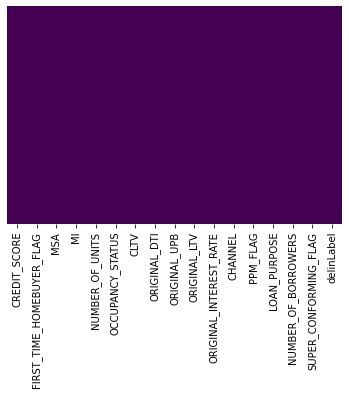

In [49]:
#check missing data visually
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [50]:
data.columns

Index(['CREDIT_SCORE', 'FIRST_TIME_HOMEBUYER_FLAG', 'MSA', 'MI',
       'NUMBER_OF_UNITS', 'OCCUPANCY_STATUS', 'CLTV', 'ORIGINAL_DTI',
       'ORIGINAL_UPB', 'ORIGINAL_LTV', 'ORIGINAL_INTEREST_RATE', 'CHANNEL',
       'PPM_FLAG', 'LOAN_PURPOSE', 'NUMBER_OF_BORROWERS',
       'SUPER_CONFORMING_FLAG', 'delinLabel'],
      dtype='object')

##### Change categorical data into dummy variable

In [51]:
data.head()

,CREDIT_SCORE,FIRST_TIME_HOMEBUYER_FLAG,MSA,MI,NUMBER_OF_UNITS,OCCUPANCY_STATUS,CLTV,ORIGINAL_DTI,ORIGINAL_UPB,ORIGINAL_LTV,ORIGINAL_INTEREST_RATE,CHANNEL,PPM_FLAG,LOAN_PURPOSE,NUMBER_OF_BORROWERS,SUPER_CONFORMING_FLAG,delinLabel
0,751,0,0.0,0,0,P,91,28,117000,80,5.250,R,0,N,2,0,0
1,730,0,1.0,0,0,P,74,50,278000,74,4.500,R,0,C,1,0,0
2,786,0,1.0,0,0,P,76,48,245000,76,5.625,C,0,N,2,0,0
3,744,0,1.0,0,0,P,79,53,250000,79,4.750,R,0,N,1,0,0
4,790,0,1.0,0,0,P,68,46,379000,68,5.125,R,0,N,2,0,0


In [52]:
# find columns that needs to change to dummy variable
# NUMBER_OF_BORROWERS doesn't need to change, but we need to specify its two value is 2 and 1 
for i in ['OCCUPANCY_STATUS','CHANNEL','LOAN_PURPOSE','NUMBER_OF_BORROWERS']:
    print(i)
    print(data[i].unique())

OCCUPANCY_STATUS
['P' 'S' 'I']
CHANNEL
['R' 'C' 'B']
LOAN_PURPOSE
['N' 'C' 'P']
NUMBER_OF_BORROWERS
[2 1]


In [53]:
# we drop first feature to avoid feature cancel each other
OCCUPANCY_STATUS = pd.get_dummies(data['OCCUPANCY_STATUS'],drop_first=True)
CHANNEL = pd.get_dummies(data['CHANNEL'],drop_first=True)
LOAN_PURPOSE = pd.get_dummies(data['LOAN_PURPOSE'],drop_first=True)
data.drop(['OCCUPANCY_STATUS','CHANNEL','LOAN_PURPOSE'],axis=1,inplace=True)
data_dummy = pd.concat([data,OCCUPANCY_STATUS,CHANNEL,LOAN_PURPOSE],axis=1)

In [54]:
data_dummy.columns

Index(['CREDIT_SCORE', 'FIRST_TIME_HOMEBUYER_FLAG', 'MSA', 'MI',
       'NUMBER_OF_UNITS', 'CLTV', 'ORIGINAL_DTI', 'ORIGINAL_UPB',
       'ORIGINAL_LTV', 'ORIGINAL_INTEREST_RATE', 'PPM_FLAG',
       'NUMBER_OF_BORROWERS', 'SUPER_CONFORMING_FLAG', 'delinLabel', 'P', 'S',
       'C', 'R', 'N', 'P'],
      dtype='object')

In [55]:
data_dummy.columns=['CREDIT_SCORE', 'FIRST_TIME_HOMEBUYER_FLAG', 'MSA', 'MI',
       'NUMBER_OF_UNITS', 'CLTV', 'ORIGINAL_DTI', 'ORIGINAL_UPB',
       'ORIGINAL_LTV', 'ORIGINAL_INTEREST_RATE', 'PPM_FLAG',
       'NUMBER_OF_BORROWERS', 'SUPER_CONFORMING_FLAG', 'delinLabel', 'OCCUPANCY_STATUS_P', 'OCCUPANCY_STATUS_S',
       'CHANNEL_C', 'CHANNEL_R', 'LOAN_PURPOSE_N', 'LOAN_PURPOSE_P']

#### Collinearity Check

#### Check correlation between variables

In [56]:
data_dummy.corr()

,CREDIT_SCORE,MSA,MI,NUMBER_OF_UNITS,CLTV,ORIGINAL_DTI,ORIGINAL_UPB,ORIGINAL_LTV,ORIGINAL_INTEREST_RATE,NUMBER_OF_BORROWERS,OCCUPANCY_STATUS_P,OCCUPANCY_STATUS_S,CHANNEL_C,CHANNEL_R,LOAN_PURPOSE_N,LOAN_PURPOSE_P
CREDIT_SCORE,1.000000,0.041386,-0.047295,-0.016713,-0.108962,-0.205709,0.047653,-0.107090,-0.242386,0.015817,-0.020787,0.034119,0.007051,0.008298,0.086425,-0.021358
MSA,0.041386,1.000000,-0.001307,-0.030487,-0.013998,0.008106,0.169152,-0.027521,-0.011327,-0.030137,0.107452,-0.143574,0.063011,-0.107468,-0.014426,0.046880
MI,-0.047295,-0.001307,1.000000,-0.039755,0.423109,-0.003139,-0.054368,0.446978,0.051508,-0.043795,0.081700,-0.059183,0.020685,-0.000851,-0.066550,0.275996
NUMBER_OF_UNITS,-0.016713,-0.030487,-0.039755,1.000000,-0.042365,0.048143,0.042237,-0.037641,0.097344,-0.026542,-0.122766,-0.024005,-0.004877,-0.005376,-0.022585,0.009046
CLTV,-0.108962,-0.013998,0.423109,-0.042365,1.000000,0.095353,0.029370,0.953175,0.145966,-0.068558,0.029310,-0.027172,0.015699,-0.024360,-0.096143,0.346499
ORIGINAL_DTI,-0.205709,0.008106,-0.003139,0.048143,0.095353,1.000000,0.094736,0.089697,0.125653,-0.139581,-0.023134,-0.002162,-0.005863,-0.049960,-0.083618,0.053402
ORIGINAL_UPB,0.047653,0.169152,-0.054368,0.042237,0.029370,0.094736,1.000000,-0.012142,-0.124933,0.175782,0.055482,0.010863,0.050881,-0.133483,0.103008,-0.047949
ORIGINAL_LTV,-0.107090,-0.027521,0.446978,-0.037641,0.953175,0.089697,-0.012142,1.000000,0.163039,-0.086488,0.011893,-0.015637,0.018295,-0.032113,-0.138099,0.371399
ORIGINAL_INTEREST_RATE,-0.242386,-0.011327,0.051508,0.097344,0.145966,0.125653,-0.124933,0.163039,1.000000,-0.096377,-0.165308,-0.002023,-0.017939,-0.030357,-0.198853,0.203123
NUMBER_OF_BORROWERS,0.015817,-0.030137,-0.043795,-0.026542,-0.068558,-0.139581,0.175782,-0.086488,-0.096377,1.000000,-0.020705,0.036541,-0.006796,0.023088,0.073367,-0.103183


##### There is no obvious correlation in variables

### Second Part: Data modeling

In [15]:
data=pd.read_csv('data_dummy')

In [3]:
# data=data[['CREDIT_SCORE', 'FIRST_TIME_HOMEBUYER_FLAG', 'MSA', 'MI',
#        'NUMBER_OF_UNITS',  'ORIGINAL_DTI', 'ORIGINAL_UPB',  'PPM_FLAG',
#        'NUMBER_OF_BORROWERS', 'SUPER_CONFORMING_FLAG', 'delinLabel']]

In [16]:
# split data into training data and testing data
from sklearn.model_selection import train_test_split
y=data.copy()['delinLabel']
X=data.copy()
X.drop('delinLabel',axis=1,inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.60)

##### Run a default logistic regression model

In [17]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

In [18]:
# evaluation
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     28926
           1       0.00      0.00      0.00       206

    accuracy                           0.99     29132
   macro avg       0.50      0.50      0.50     29132
weighted avg       0.99      0.99      0.99     29132



C:\Installs\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Installs\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Installs\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[28926,     0],
       [  206,     0]], dtype=int64)

* We run a default logistic regression model, the report and confusion metric shows that the modle simply predict every loan will not be delinquency.
* This is because the delinquency data is a very small portion of whole data. 
* Next step we will try to solve this problem by rebalance the data.

#### Rebalance data (under sample class 0) 


In [19]:
d=pd.concat([X,y],axis=1)
count_class_0, count_class_1 = d.delinLabel.value_counts()
df_class_0 = d[d['delinLabel'] == 0]
df_class_1 = d[d['delinLabel'] == 1]

In [20]:
# under sample class 0
df_class_0_under = df_class_0.sample(count_class_1)
d_rebalanced = pd.concat([df_class_0_under, df_class_1], axis=0)

<AxesSubplot:title={'center':'Count (target)'}>

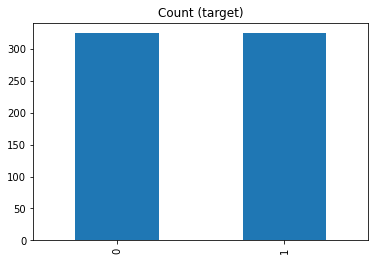

In [21]:
# the rebalanced data has uniform distribution of delinLabel
d_rebalanced.delinLabel.value_counts().plot(kind='bar', title='Count (target)')

### bootstrapping data into training and testing datasets
After data rebalancing, the size of data become smaller. So I apply boostrapping method which is suitable for small dataset

In [29]:
temp_sample = np.random.choice(list(range(len(d_rebalanced))), replace=True, size=len(d_rebalanced))
test_index=[i for i in list(range(len(d_rebalanced))) if i not in temp_sample]
train_index=[i for i in list(range(len(d_rebalanced))) if i not in test_index]

In [30]:
columns=['CREDIT_SCORE', 'FIRST_TIME_HOMEBUYER_FLAG', 'MSA', 'MI',
       'NUMBER_OF_UNITS', 'CLTV', 'ORIGINAL_DTI', 'ORIGINAL_UPB',
       'ORIGINAL_LTV', 'ORIGINAL_INTEREST_RATE', 'PPM_FLAG',
       'NUMBER_OF_BORROWERS', 'SUPER_CONFORMING_FLAG', 
       'OCCUPANCY_STATUS_P', 'OCCUPANCY_STATUS_S', 'CHANNEL_C', 'CHANNEL_R',
       'LOAN_PURPOSE_N', 'LOAN_PURPOSE_P']
X_train=d_rebalanced.iloc[train_index][columns]
y_train=d_rebalanced.iloc[train_index]['delinLabel']
X_test=d_rebalanced.iloc[test_index][columns]
y_test=d_rebalanced.iloc[test_index]['delinLabel']

In [31]:
# run model again
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

In [32]:
# evaluation
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

              precision    recall  f1-score   support

           0       0.74      0.73      0.73       117
           1       0.73      0.74      0.73       115

    accuracy                           0.73       232
   macro avg       0.73      0.73      0.73       232
weighted avg       0.73      0.73      0.73       232



array([[85, 32],
       [30, 85]], dtype=int64)

#### Conclusion: 
The result is better, the model begins to capture the delinquency pattern from the features and build model. But the performance is only 20% higher than 50%. It's far from good. The reason might be the dataset is still too small after rebalaning.

#### Interpreting the coefficient of the model

In [33]:
# Create a list of original variable names from the training DataFrame
original_variables = X_train.columns

# Extract the coefficients of the logistic regression estimator
model_coefficients = logmodel.coef_[0]

# Create a dataframe of the variables and coefficients & print it out
coefficient_df = pd.DataFrame({"Variable" : original_variables, "Coefficient": model_coefficients})

print(coefficient_df)

                     Variable   Coefficient
0                CREDIT_SCORE -9.036650e-03
1   FIRST_TIME_HOMEBUYER_FLAG -7.065357e-04
2                         MSA  2.283706e-04
3                          MI  6.787870e-05
4             NUMBER_OF_UNITS  1.756443e-04
5                        CLTV  2.294141e-02
6                ORIGINAL_DTI  8.512943e-02
7                ORIGINAL_UPB -4.381409e-08
8                ORIGINAL_LTV  2.581124e-02
9      ORIGINAL_INTEREST_RATE  4.159831e-03
10                   PPM_FLAG  9.277137e-05
11        NUMBER_OF_BORROWERS -1.608968e-03
12      SUPER_CONFORMING_FLAG -8.892547e-05
13         OCCUPANCY_STATUS_P  8.912031e-04
14         OCCUPANCY_STATUS_S -3.824636e-04
15                  CHANNEL_C  4.884964e-04
16                  CHANNEL_R -1.191511e-03
17             LOAN_PURPOSE_N -1.708410e-04
18             LOAN_PURPOSE_P -1.625945e-03


From the coefficient of the model, we can find the higher the credit score and number of borrowers the lower the probability of delinquency is.
If the borrower is first time home buyer, the loan is from retail, the loan purpose is refinance with on cash out, the probability of delinquency is lower.

### Use SMOTE technology to solve the class imbalance problem 

After the data rebalance process, the performance of the model is still not ideal.
Next step I tried to use SMOTE technology.


SMOTE is referred to as the Synthetic Minority Oversampling Technique which oversample the examples in the minority class by synthesizing new examples from the minority class. 

It works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

In [35]:

y=data.copy()
y=y.delinLabel
X=data.copy()
X.drop('delinLabel',axis=1,inplace=True)

In [36]:
# define pipeline
over=SMOTE(sampling_strategy=0.1)
under=RandomUnderSampler(sampling_strategy=0.5)
model=LogisticRegression()
steps=[('o',over),('u', under),('m',model)]
pipeline=Pipeline(steps=steps)

In [39]:
# evaluate pipeline by 10 fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores

array([0.87067545, 0.85275947, 0.84740527, 0.85272915, 0.86096807,
       0.86549949, 0.85664264, 0.85025747, 0.8523172 , 0.85643666,
       0.84987644, 0.85687809, 0.85873147, 0.85499485, 0.84552008,
       0.89989701, 0.86035015, 0.84716787, 0.86343975, 0.84696189,
       0.85996705, 0.84884679, 0.85008237, 0.87044284, 0.85932029,
       0.87312049, 0.85087539, 0.85066941, 0.84572606, 0.86426365])

In [40]:
scores.mean()

0.857427427240609

We can see the performance of the model is dramatically improved.

We can see variable CLTV (ORIGINAL COMBINED LOAN-TO-VALUE),LTV (ORIGINAL LOAN-TO-VALUE) have very high VIF score. This makes sense since they are quite similar based on definition.CREDIT_SCORE and ORIGINAL_INTEREST_RATE also have very high VIF score. Since the higher the credit score is, the lower the interest rate


We will remove variables that have VIF score higher than 20.

#### Modeling

In [138]:
# data_m=data_dummy[[ 'FIRST_TIME_HOMEBUYER_FLAG', 'MSA', 'MI','NUMBER_OF_UNITS', 'ORIGINAL_DTI', 'ORIGINAL_UPB',
#          'PPM_FLAG','NUMBER_OF_BORROWERS', 'SUPER_CONFORMING_FLAG', 'delinLabel',  'OCCUPANCY_STATUS_S','CHANNEL_C',
#          'CHANNEL_R', 'LOAN_PURPOSE_N', 'LOAN_PURPOSE_P']]
# #data_m=data_dummy

In [139]:
y=data_m.copy()['delinLabel']
X=data_m.copy()
X.drop('delinLabel',axis=1,inplace=True)

In [140]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.60)

In [135]:
X.shape

(48553, 19)

In [137]:
y.shape

(48553,)

In [142]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_dummy.drop('delinLabel',axis=1), 
                                                    data_dummy['delinLabel'], test_size=0.60, 
                                                    random_state=101)

In [145]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

ValueError: Unknown label type: 'unknown'

In [94]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

array([[28948,     0],
       [  184,     0]], dtype=int64)

* We run a default logistic regression model, the report and confusion metric shows that the modle simply predict every loan will not be delinquency.
* This is because the delinquency data is a very small portion of data. 
* Next step we will try to solve this problem by rebalance the data.

In [ ]:
##### rebalance the data

In [130]:
d=pd.concat([X,y],axis=1)

<AxesSubplot:title={'center':'Count (target)'}>

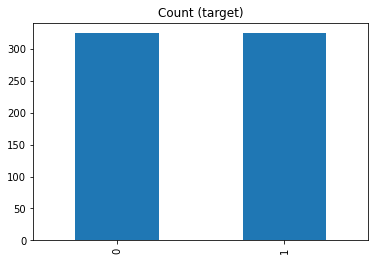

In [131]:
count_class_0, count_class_1 = d.delinLabel.value_counts()
df_class_0 = d[d['delinLabel'] == 0]
df_class_1 = d[d['delinLabel'] == 1]
# under sample class 0
df_class_0_under = df_class_0.sample(count_class_1)
d_rebalanced = pd.concat([df_class_0_under, df_class_1], axis=0)
# the rebalanced data has uniform distribution of delinLabel
d_rebalanced.delinLabel.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
### boostrapping data into training and testing datasets

In [132]:
temp_sample = np.random.choice(list(range(len(d_rebalanced))), replace=True, size=len(d_rebalanced))
test_index=[i for i in list(range(len(d_rebalanced))) if i not in temp_sample]
train_index=[i for i in list(range(len(d_rebalanced))) if i not in test_index]

In [133]:
columns=['FIRST_TIME_HOMEBUYER_FLAG', 'MSA', 'MI','NUMBER_OF_UNITS', 'ORIGINAL_DTI', 'ORIGINAL_UPB',
        'PPM_FLAG','NUMBER_OF_BORROWERS', 'SUPER_CONFORMING_FLAG', 'delinLabel',  'OCCUPANCY_STATUS_S','CHANNEL_C',
        'CHANNEL_R', 'LOAN_PURPOSE_N', 'LOAN_PURPOSE_P']
X_train=d_rebalanced.iloc[train_index][columns]
y_train=d_rebalanced.iloc[train_index]['delinLabel']
X_test=d_rebalanced.iloc[test_index][columns]
y_test=d_rebalanced.iloc[test_index]['delinLabel']

In [104]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       132
         1.0       0.48      1.00      0.65       122

    accuracy                           0.48       254
   macro avg       0.24      0.50      0.32       254
weighted avg       0.23      0.48      0.31       254



C:\Installs\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Installs\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Installs\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[  0, 132],
       [  0, 122]], dtype=int64)

In [66]:
#### check VIF

In [74]:
# make sure there is no object datatype in dataframe
for i in data_dummy.columns:
    data_dummy[i] = data_dummy[i].astype(float)

In [76]:
# calculate VIF
vif = pd.DataFrame()
vif["variables"] = data_dummy.columns
vif["VIF"] = [variance_inflation_factor(data_dummy.values, i) for i in range(len(data_dummy.columns))]

In [77]:
vif.sort_values('VIF',ascending=False)

,variables,VIF
5,CLTV,216.404377
8,ORIGINAL_LTV,211.023732
0,CREDIT_SCORE,159.874049
9,ORIGINAL_INTEREST_RATE,137.966813
14,OCCUPANCY_STATUS_P,36.491932
11,NUMBER_OF_BORROWERS,12.424359
6,ORIGINAL_DTI,9.588819
7,ORIGINAL_UPB,6.891595
2,MSA,6.266209
17,CHANNEL_R,4.045977


In [70]:
# calculate VIF
for i in data_dummy.columns:
    data_dummy[i] = data_dummy[i].astype(float)
data_dummy_2=data_dummy[[  'FIRST_TIME_HOMEBUYER_FLAG', 'MSA', 'MI',
       'NUMBER_OF_UNITS',  'ORIGINAL_DTI', 'ORIGINAL_UPB',
         'PPM_FLAG',
       'NUMBER_OF_BORROWERS', 'SUPER_CONFORMING_FLAG',  'OCCUPANCY_STATUS_P', 'OCCUPANCY_STATUS_S',
       'CHANNEL_C', 'CHANNEL_R', 'LOAN_PURPOSE_N', 'LOAN_PURPOSE_P']]
vif = pd.DataFrame()
vif["variables"] = data_dummy_2.columns
vif["VIF"] = [variance_inflation_factor(data_dummy_2.values, i) for i in range(len(data_dummy_2.columns))]

In [71]:
vif.sort_values('VIF',ascending=False)

,variables,VIF
9,OCCUPANCY_STATUS_P,19.529774
7,NUMBER_OF_BORROWERS,10.498882
4,ORIGINAL_DTI,7.830374
5,ORIGINAL_UPB,6.642613
1,MSA,5.785505
12,CHANNEL_R,3.791196
11,CHANNEL_C,2.674449
14,LOAN_PURPOSE_P,2.632551
13,LOAN_PURPOSE_N,2.371093
10,OCCUPANCY_STATUS_S,1.745255


In [74]:
data_dummy_2=data_dummy[[  'FIRST_TIME_HOMEBUYER_FLAG', 'MSA', 'MI',
       'NUMBER_OF_UNITS',  'ORIGINAL_DTI', 'ORIGINAL_UPB',
         'PPM_FLAG',
       'NUMBER_OF_BORROWERS', 'SUPER_CONFORMING_FLAG',  'OCCUPANCY_STATUS_P', 'OCCUPANCY_STATUS_S',
       'CHANNEL_C', 'CHANNEL_R', 'LOAN_PURPOSE_N', 'LOAN_PURPOSE_P','delinLabel']]

In [75]:
#try smote
y=data_dummy_2.copy()
y=y.delinLabel
X=data_dummy_2.copy()
X.drop('delinLabel',axis=1,inplace=True)

In [76]:
over=SMOTE(sampling_strategy=0.1)
under=RandomUnderSampler(sampling_strategy=0.5)
model=LogisticRegression()
steps=[('o',over),('u', under),('m',model)]
pipeline=Pipeline(steps=steps)

In [77]:
# evaluate pipeline by 10 fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=1)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores

array([0.99320428, 0.99320428, 0.99320428, 0.99340886, 0.99340886,
       0.99340886, 0.99340886, 0.99340886, 0.99340886, 0.99320288,
       0.99320428, 0.99320428, 0.99320428, 0.99340886, 0.99340886,
       0.99340886, 0.99340886, 0.99340886, 0.99340886, 0.99320288,
       0.99320428, 0.99320428, 0.99320428, 0.99340886, 0.99340886,
       0.99340886, 0.99340886, 0.99340886, 0.99340886, 0.99320288])

In [78]:
scores.mean()

0.9933268874799162

In [82]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores

array([0.88612026, 0.8943575 , 0.89147446, 0.99340886, 0.90030896,
       0.99340886, 0.89207003, 0.99340886, 0.88135942, 0.99320288,
       0.88591433, 0.91659802, 0.89250412, 0.99340886, 0.91225541,
       0.99340886, 0.99340886, 0.89557158, 0.99340886, 0.99320288,
       0.89271005, 0.87808896, 0.99320428, 0.90937178, 0.99340886,
       0.88362513, 0.99340886, 0.99340886, 0.99340886, 0.88836251])

In [83]:
scores.mean()

0.940260000192287

In [64]:
y=data_dummy_2.copy()['delinLabel']
X=data_dummy_2.copy()
X.drop('delinLabel',axis=1,inplace=True)

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.60)

In [66]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     28902
         1.0       0.00      0.00      0.00       230

    accuracy                           0.99     29132
   macro avg       0.50      0.50      0.50     29132
weighted avg       0.98      0.99      0.99     29132



C:\Installs\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Installs\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Installs\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

array([[28902,     0],
       [  230,     0]], dtype=int64)

In [78]:
#try smote
y=data_dummy.copy()
y=y.delinLabel
X=data_dummy.copy()
X.drop('delinLabel',axis=1,inplace=True)

In [79]:
# define pipeline
over=SMOTE(sampling_strategy=0.1)
under=RandomUnderSampler(sampling_strategy=0.5)
model=LogisticRegression()
steps=[('o',over),('u', under),('m',model)]
pipeline=Pipeline(steps=steps)

In [80]:
# evaluate pipeline by 10 fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=1)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores

array([0.99320428, 0.99320428, 0.99320428, 0.99340886, 0.99340886,
       0.99340886, 0.99340886, 0.99340886, 0.99340886, 0.99320288,
       0.99320428, 0.99320428, 0.99320428, 0.99340886, 0.99340886,
       0.99340886, 0.99340886, 0.99340886, 0.99340886, 0.99320288,
       0.99320428, 0.99320428, 0.99320428, 0.99340886, 0.99340886,
       0.99340886, 0.99340886, 0.99340886, 0.99340886, 0.99320288])

In [81]:
scores.mean()

0.9933268874799162

In [82]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores

array([0.86882208, 0.85193575, 0.8502883 , 0.86467559, 0.85932029,
       0.8554068 , 0.84449022, 0.85128733, 0.84902163, 0.85005149,
       0.84987644, 0.8696458 , 0.85934926, 0.85932029, 0.85375901,
       0.85334706, 0.86323378, 0.85128733, 0.86220391, 0.84654995,
       0.86140857, 0.85440692, 0.84019769, 0.85396498, 0.85623069,
       0.87476828, 0.85396498, 0.84984552, 0.84881565, 0.85355304])

In [83]:
scores.mean()

0.8553676214843305